In [3]:
import mpmath as mp
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from mpmath import *
from mpl_toolkits.mplot3d import Axes3D
mp.dps = 15; mp.pretty = True
from numba import jit

#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#tf.__version__

# Custom activation function
#from keras.layers import Activation
#from keras import backend as K
#from keras.utils.generic_utils import get_custom_objects

!conda list scikit-learn

# packages in environment at /Users/minwookim/opt/anaconda3:
#
# Name                    Version                   Build  Channel
scikit-learn              1.1.1                    pypi_0    pypi


In [4]:
# Normalise X value with choosen range
def xnorm (x,maxrange,minrange):
    # Separate the dimensions
    n=[]
    for j in range(x.shape[1]):
        temp=[]
        for i in range(x.shape[0]):
            temp.append(x[i][j])
        rex=(maxrange-minrange)/(np.max(temp)-np.min(temp))*(np.array(temp)-np.min(temp))+minrange
        n.append(rex)
    a=[]
    for i in range(x.shape[0]):
        r=[]
        for j in range(x.shape[1]):
            r.append(n[j][i])
        a.append(r)
    return np.array(a)

# Normalise Y value with choosen range
def ynorm (func,maxrange,minrange):
    rex=(maxrange-minrange)/(np.max(func)-np.min(func))*(np.array(func)-np.min(func))+minrange
    return rex

# Decode Normalised integrated value
def decode(func,x,maxrange,minrange,inte):
    v={}
    for j in range(x.shape[1]):
        temp=[]
        for i in range(x.shape[0]):
            temp.append(x[i][j])
        v[j]=np.max(temp)-np.min(temp)
    product=1
    for i in range(x.shape[1]):
        product=product*v[i]
    vs=product
    vss=(maxrange-minrange)**x.shape[1]
    f=np.max(func)-np.min(func)
    yy=maxrange-minrange
    return vs*f*inte/(vss*yy)+(np.min(func)-f/yy*minrange)*vs

# Initial function
def init(dim):
    # number of function dimension
    dim = dim
    # training set of N
    N = 3000*dim**3
    # random x grid
    x = np.random.random((N,dim))
    # set the maximum dimension
    MAX_DIM=20
    # set the random variables of u and c
    np.random
    u = np.random.random((dim,))
    cs = np.random.random((MAX_DIM,))
    cs = cs[:x.shape[1]]
    return dim, N, x, u, cs

# function for fitting
# y value
def oscil(x):
    arg = np.dot(x,cs)
    arg += u[0] * 2 * np.pi
    return np.cos(arg)

def prod(x):
    temp={}
    for i in range(x.shape[1]):
        temp2=[]
        for j in range(x.shape[0]):
            temp2.append(x[j][i])
        temp[i]=(cs[i]**(-2)+(temp2-u[i])**2)**(-1)
    product=1
    for i in range(x.shape[1]):
        product=product*temp[i]
    return product

# function graph
def graph(dim,x,y):
    if dim == 1:
        plt.scatter(x,y)
        plt.show()
    elif dim == 2:
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(projection='3d')
        x1=[j[0] for j in x]
        x2=[j[1] for j in x]
        ax.scatter(x1, x2, y)
        plt.show()
    elif dim == 3:
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(projection='3d')
        x1 = [j[0] for j in x]
        x2 = [j[1] for j in x]
        x3 = [j[2] for j in x]
        img = ax.scatter(x1, x2, x3, c=y, cmap=plt.hot())
        fig.colorbar(img)
        plt.show()
    elif dim == 4:
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(projection='3d')
        x1 = [j[0] for j in x]
        x2 = [j[1] for j in x]
        x3 = [j[2] for j in x]
        x4 = [j[3]*30 for j in x]
        img = ax.scatter(x1, x2, x3, c=y,s=x4, cmap=plt.hot())
        fig.colorbar(img)
        plt.show()

# number of nodes (k) tunable parameter k1,k2
def node(dim,N):
    k1 = 4.33
    k2 = 16
    #k = math.floor(((np.log10(N)**(-k1))*(k2*N/(dim+2))))
    k = math.floor(10*dim*np.log10(N)**1.5)
    return k

# weight and bias of input and output
def sk_coe(mlpr):
    weight_input = []
    weight_output = mlpr.coefs_[1]
    bias_input = mlpr.intercepts_[0]
    bias_output = mlpr.intercepts_[1]
    for i in range(dim):
        weight_input.append(mlpr.coefs_[0][i])
    return weight_input, weight_output, bias_input, bias_output

def tf_coe(mlpr):
    weight_input = []
    weight_output = mlpr.layers[1].get_weights()[0]
    bias_input = mlpr.layers[0].get_weights()[1]
    bias_output = mlpr.layers[1].get_weights()[1]
    for i in range(dim):
        weight_input.append(mlpr.layers[0].get_weights()[0][i])
    return weight_input, weight_output, bias_input, bias_output

# sign of sigmoid integration
def addIndex(l):
    ret = []
    for v in l:
        ret.append(v+[0])
        ret.append(v+[1])
    return ret 

def sigs(l):
    return int((-1)**(sum(l)-len(l)))

def sig_lims(n):
    ret = [[]]
    for i in range(n):
        ret = addIndex(ret)
    if n%2==0:
        signs = [sigs(x) for x in ret]
    else:
        signs = [-1*sigs(x) for x in ret]
    return ret, signs
def re_lims(n):
    ret = [[]]
    for i in range(n):
        ret = addIndex(ret)

    signs = [sigs(x) for x in ret]
    return ret, signs

# fixed input values
def inpf(fix):
    return np.random.random((100,fix))

# numerical calculation of integral
# Sigmoid
def sig_integral(dim,fix,inp):
    vecpoly = np.vectorize(fp.polylog, signature='(),()->()', otypes=[float])
    if fix > 0:
        dim=dim-fix
        cons=np.dot(inp,weight_input[dim:])
        poly =[]
        for i in range(len(sig_lims(dim)[1])):
            weight=np.array(weight_input[:dim]).T*sig_lims(dim)[0][i]
            temp=sig_lims(dim)[1][i]*vecpoly(dim,-np.exp(-(bias_input+cons)-sum(weight.T)))
            poly.append(np.array(temp))
        sumpoly=np.sum(poly,axis=0)
        result=(bias_output+np.sum((1+sumpoly/np.prod(weight_input[:dim],axis=0))*weight_output.T,axis=1))
        return result
    else:
        poly =[]
        for i in range(len(sig_lims(dim)[1])):
            weight=np.array(weight_input[:dim]).T*sig_lims(dim)[0][i]
            temp=sig_lims(dim)[1][i]*vecpoly(dim,-np.exp(-bias_input-sum(weight.T)))
            poly.append(np.array(temp))
        sumpoly=np.sum(poly,axis=0)
        result=(bias_output+np.sum((1+sumpoly/np.prod(weight_input[:dim],axis=0))*weight_output.T))[0]
        return result
# Relu
def re_integral(dim,fix,inp):
    def relu(x):
        return np.clip(x,a_min=0.0, a_max=None)
    if fix > 0:
        temp=0
        dim=dim-fix
        cons=np.dot(inp,weight_input[dim:])
        for i in range(len(re_lims(dim)[1])):
            weight=np.array(weight_input[:dim]).T*re_lims(dim)[0][i]
            temp+=re_lims(dim)[1][i]*1/np.prod(np.arange(dim+2)[1:])*relu(bias_input+cons+sum(weight.T))**(dim+1)/np.prod(weight_input[:dim],axis=0)
        result=(bias_output+np.sum(temp*weight_output.T,axis=1))
        return result
    else:
        poly =[]
        temp=0
        for i in range(len(re_lims(dim)[1])):
            weight=np.array(weight_input[:dim]).T*re_lims(dim)[0][i]
            temp+=re_lims(dim)[1][i]*1/np.prod(np.arange(dim+2)[1:])*relu(bias_input+sum(weight.T))**(dim+1)/np.prod(weight_input,axis=0)
        result=(bias_output+np.sum(temp*weight_output.T[0]))[0]
        return result

# analytical integral value
# Oscillatory
def symbolicval(ndiff, nfix,inp):
    arest = cs[ndiff:]
    adiff = cs[:ndiff]
    norm = 2**ndiff*np.prod(np.sin(adiff/2))/np.prod(adiff)
    arg = 2*np.pi*u[0] + sum(adiff)/2
    if nfix == 0:
        F = norm*np.cos(arg)
    else:
        F = norm*np.cos(arg+np.dot(inp,arest))
    return F

# Product peak
def symbolicval2(ndiff, nfix):
    temp=[]
    for i in range(ndiff):
        temp.append(cs[i]*(np.arctan(cs[i]*u[i])+np.arctan(cs[i]-cs[i]*u[i])))
    product=1
    for i in range(ndiff):
        product=product*temp[i]
    if nfix ==0:
        F=product
    else:
        temp={}
        for i in range(x.shape[1]):
            temp2=[]
            for j in range(x.shape[0]):
                temp2.append(x[j][i])
            temp[i]=(cs[i]**(-2)+(temp2-u[i])**2)**(-1)
        product2=1
        for i in range(nfix):
            product2=product2*temp[i+nfix]
            F=product2
        return F*prod(x)
    return F

size of x, cs and u
(24000, 2)
(2,)
(2,)
original function graph(dim<=4)


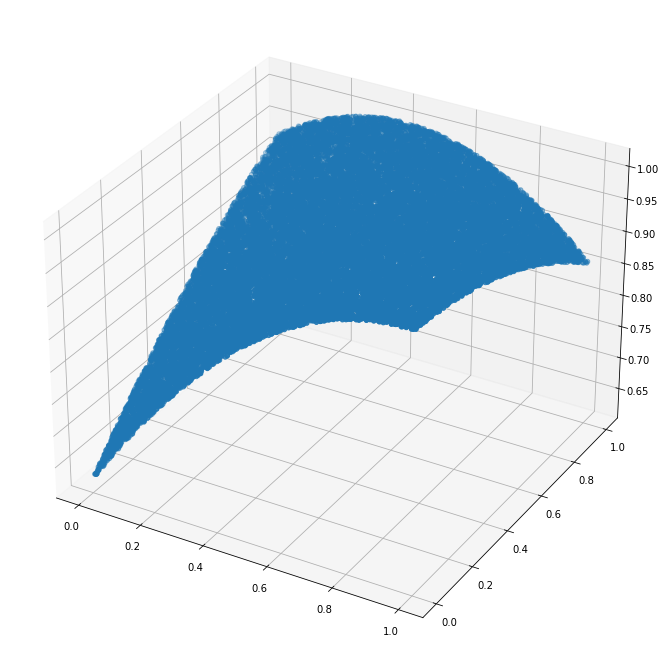

number of nodes
183
Y Min: 0.6291109860286328 Y Max: 0.9999999987602679


In [455]:
# Original values

dim, N, x, u, cs = init(2)
y = oscil(x)
#y = prod(x)
# test and validation divide 95%
trainx, testx, trainy, testy = train_test_split(x, y, test_size = 0.05)
k = node(dim,N)

print('size of x, cs and u')
print(x.shape)
print(cs.shape)
print(u.shape)
print('original function graph(dim<=4)')
graph(dim,x,y)
print('number of nodes')
print(k)
print('Y Min:',np.min(y),'Y Max:',np.max(y))

In [456]:
# Keras fitting sigmoid
model = keras.Sequential([
    keras.layers.Dense(k, activation='sigmoid'),
    keras.layers.Dense(1)
])

# Keras custom activation fitting
def custom_activation(x):
    return x**3

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

model2 = keras.Sequential([
    keras.layers.Dense(k),
    keras.layers.Dense(1)
])
model2.add(Activation(custom_activation, name='SpecialActivation'))

# Keras sigmoid backpropagation
model.compile(
    loss=tf.keras.losses.mae,
    optimizer='adam',
    metrics=['mae']
)

# Keras Custom activation backpropagation
model2.compile(
    loss=tf.keras.losses.mae,
    optimizer='adam',
    metrics=['mae']
)

# Fitting
#model.fit(trainx, trainy, epochs=100)
#model2.fit(trainx, trainy, epochs=100)

NameError: name 'keras' is not defined

In [457]:
start = timeit.default_timer()
# mlpregression with Sigmoid activation adam backpropagation
mlp_reg = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'logistic', n_iter_no_change=100,
                       solver = 'lbfgs', learning_rate_init=0.001,
                       learning_rate ='adaptive', tol=1e-10)
# fitting NN
mlp_reg.fit(trainx, trainy)
#print('convergence: ',len(mlp_reg.loss_curve_))
#print('loss: ', mlp_reg.best_loss_)
stop = timeit.default_timer()
print('Time: ', stop - start)  

Time:  1.1588949580327608


In [458]:
start = timeit.default_timer()
# mlpregression with relu activation with changed hyperparameter lbfgs
mlp_reg_re_lb = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 1000000000,activation = 'relu',
                       solver = 'lbfgs',
                       learning_rate_init=0.0005, tol=1e-10)
# fitting NN
mlp_reg_re_lb.fit(trainx, trainy)
print('Convergence: ',mlp_reg_re_lb.n_iter_)
stop = timeit.default_timer()
print('Time: ', stop - start)  

Convergence:  76
Time:  2.635300207999535


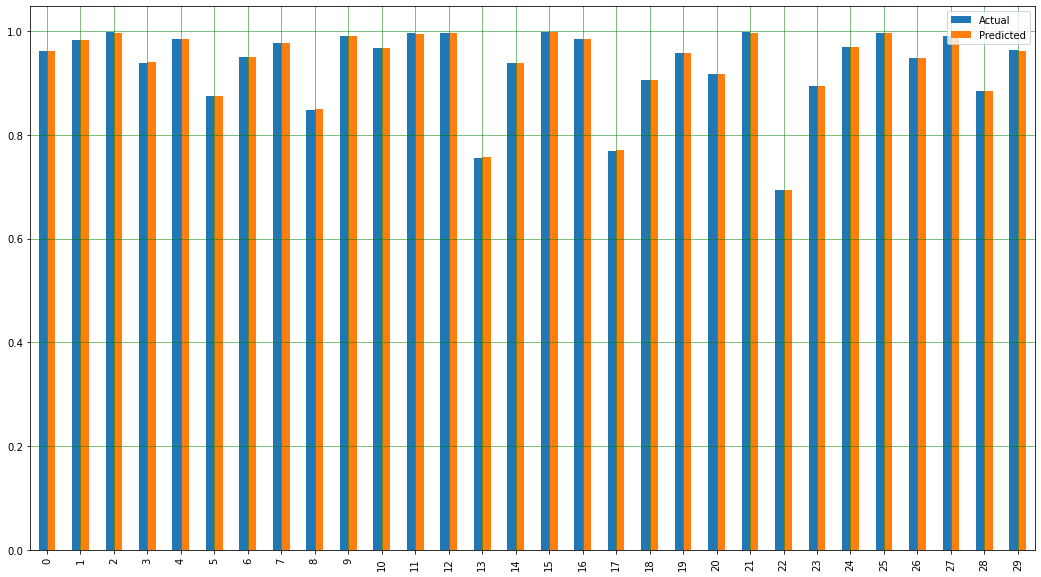

Mean Absolute Error: 0.0006600991074211097
Mean Squared Error: 7.346527136305965e-07
Root Mean Squared Error: 0.0008571188445195896


In [459]:
# Prediction
y_pred = mlp_reg_re_lb.predict(testx)
df_temp = pd.DataFrame({'Actual': testy, 'Predicted': y_pred})
df_temp.head()
# graph of predict and validation
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(18,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()
# MSE and Loss
print('Mean Absolute Error:', metrics.mean_absolute_error(testy, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(testy, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testy, y_pred)))
#plt.plot(mlp_reg_re_lb.loss_curve_)
#plt.title("Loss Curve", fontsize=14)
#plt.xlabel('Iterations')
#plt.ylabel('Cost')
#plt.yscale('log')
plt.show()

In [465]:
print(dim)
sy=symbolicval(dim,0,0)
#print('Analytic_Oscil: ',sy)
weight_input, weight_output, bias_input, bias_output = sk_coe(mlp_reg)
sig_lb=sig_integral(dim,0,0)
weight_input, weight_output, bias_input, bias_output = sk_coe(mlp_reg_re_lb)
re_lb=re_integral(dim,0,0)
print('Relu_lbsfg: ',digit(sy,re_lb))
print('Sigmoid_lbsfg: ',digit(sy,sig_lb))
#weight_input, weight_output, bias_input, bias_output = tf_coe(model)
#sig_tf=tf_integral(dim,0)
#print('Sigmoid_tensorflow: ',sig_tf)

inval=inpf(1)
sy_f=symbolicval(dim-1,1,inval)
#print('Analytic_fix_Oscil: ',sy_f)
weight_input, weight_output, bias_input, bias_output = sk_coe(mlp_reg_re_lb)
start = timeit.default_timer()
re_lb_f=re_integral(dim,1,inval)
stop = timeit.default_timer()
print('Relu_lbsfg_fix: ',digit(sy_f,re_lb_f))
print('Time: ', stop - start)  

weight_input, weight_output, bias_input, bias_output = sk_coe(mlp_reg)
start = timeit.default_timer()
sig_lb_f=sig_integral(dim,1,inval)
stop = timeit.default_timer()
print('Sigmoid_lbsfg_fix: ',digit(sy_f,sig_lb_f))
print('Time: ', stop - start)  

2
Relu_lbsfg:  5.0768052218081845
Sigmoid_lbsfg:  3.680238111401377
Relu_lbsfg_fix:  [3.88404337 3.82351424 3.72921774 3.80773453 4.85912983 4.00686917
 3.71977282 4.53743499 4.37287234 4.09945633 4.28848338 3.60986795
 3.7558821  4.81969065 3.71557196 3.60815065 3.80811166 3.6593346
 5.48992655 3.35321561 3.85878676 3.32637137 3.56840351 3.59215321
 4.23036269 3.8685233  3.84974564 3.91220576 3.71426467 3.99641483
 4.43781527 3.64162267 3.74217327 3.75797402 3.90823718 3.78644865
 4.29598111 3.71675184 4.11748405 5.27029527 4.53294144 4.38125212
 3.76870223 3.56919507 3.75466721 4.40010257 3.56758733 3.75687474
 4.21608746 3.99390742 3.75161463 3.31864394 3.87302256 3.89187229
 3.73367216 3.40126502 3.31717457 3.58398632 3.6705734  4.01804681
 3.71521002 3.88719975 5.30164917 4.1029744  4.1567972  3.39242452
 3.87580384 4.79592515 3.34509935 4.00173078 3.6140303  4.1870374
 3.30541996 4.08819584 3.57054996 4.05440927 3.81132497 4.62806918
 3.67872462 4.98174469 3.27292221 3.18696154 3

In [11]:
from sector_3 import I0
def vec(x,y,z,k):
    temp=[]
    for i in range(len(x)):
        temp.append([x[i],y[i],z[i],k[i]])
    return np.array(temp)

def sk_coe(mlpr):
    weight_input = []
    weight_output = mlpr.coefs_[1]
    bias_input = mlpr.intercepts_[0]
    bias_output = mlpr.intercepts_[1]
    for i in range(mlpr.coefs_[0].shape[0]):
        weight_input.append(mlpr.coefs_[0][i:i+1][0])
    return weight_input, weight_output, bias_input, bias_output

def relulb():
    # mlpregression with relu activation with changed hyperparameter lbfgs
    mlp_sec1 = MLPRegressor(hidden_layer_sizes=(k,),
                           max_iter = 1000000000,activation = 'relu',
                           solver = 'lbfgs',warm_start=True,
                           learning_rate_init=0.001, tol=1e-10)
    # fitting NN
    mlp_sec1.fit(X, Y)
    return mlp_sec1

def siglb():
    # mlpregression with relu activation with changed hyperparameter lbfgs
    mlp_sec1_l = MLPRegressor(hidden_layer_sizes=(k,),
                           max_iter = 1000000000,activation = 'logistic',
                           solver = 'lbfgs',warm_start=True,
                           learning_rate_init=0.0005, tol=1e-10)
    # fitting NN
    mlp_sec1_l.fit(X, Y)
    return mlp_sec1_l

def digit(analy,numeric):
    return -np.log10(abs((analy-numeric)/analy))

def normalf(f,i):
    if i == 0:
        return f/(I0(np.array([1/2]*(dim-fix.shape[1])),inp,0))
    if f == 0:
        return i*(I0(np.array([1/2]*(dim-fix.shape[1])),inp,0))


In [17]:
dim=7
N=3000*dim**3
N=100000
k = math.floor(10*dim*np.log10(N)**1.5)
k=100
s12 = np.array(np.linspace(-3.01, -30.0, N))
s14 = np.array(np.linspace(-3.02, -29.9, N))
mh2 = np.array(np.linspace(-3.03, -29.8, N))
mt2 = np.array([1] * N)
fix=vec(s12, s14, mh2, mt2)
vari = np.random.random((N,dim-fix.shape[1]))

inp=fix[-1]#np.matrix([-30.000000000000000 ,-29.899999999999999 ,-29.800000000000001 ,1.000000000000000 ])

Y=[]
X=np.concatenate((vari,fix),axis=1)
for i in range(len(vari)):
    Y.append(I0(vari[i],fix[i],0))
Y=np.array(Y)
Y=normalf(Y,0)
print(len(Y))

100000


In [9]:
start = timeit.default_timer()
weight_input, weight_output, bias_input, bias_output = sk_coe(relulb())
re_lb_f=re_integral(7,4,inp)
print(inp)
stop = timeit.default_timer()
print('Relu_lbsfg_fix: ',digit(6.12601731250704030e-04 ,re_lb_f)[0])
print('Time: ', stop - start)  

[[-30.  -29.9 -29.8   1. ]]
Relu_lbsfg_fix:  -0.11391967947571406
Time:  4.670096124999986


In [10]:
start = timeit.default_timer()
weight_input, weight_output, bias_input, bias_output = sk_coe(siglb())
re_lb_l=sig_integral(7,4,inp)
print(inp)
stop = timeit.default_timer()
print('Sig_lbsfg_fix: ',digit(6.12601731250704030e-04 ,re_lb_l[0]))
print('Time: ', stop - start)  


[[-30.  -29.9 -29.8   1. ]]
Sig_lbsfg_fix:  -0.6174908788986796
Time:  10.505354667000006


In [349]:
print(np.array([10])*weight_output.T)
digit(6.12601731250704030e-04 ,re_integral(7,4,inp)[0])

[[ 0.13097278  0.76762795 -0.10012428 -2.82533194 -2.0719394  -2.43730108
   1.86723125  2.13427245  1.72859843  0.9009204  -0.16696852 -1.81456731
  -1.38717298 -0.82847943 -2.57560601 -0.71096039 -0.19777398  1.58873916
   1.11435916  1.0689159  -1.03271417 -0.17668636 -0.74455878  1.43054982
  -2.58191731 -2.08248278  2.23703509 -1.7146802   1.52813547 -0.63551817
   0.79863607  1.36285806  3.36530131  0.78676143 -1.86245049  0.66884181
   3.09920479 -0.54623526 -2.80952917  2.1314131  -2.55636125  0.36025847
   3.04891971 -1.30423045  1.57023232 -0.62431347 -2.1440311  -2.92706526
   0.37778689 -0.85125501]]


0.5940199609867453

In [467]:
RL_k={}
SL_k={}
inp=fix[-1:]#np.matrix([-30.000000000000000 ,-29.899999999999999 ,-29.800000000000001 ,1.000000000000000 ])
dim=7
K=[50,100,200,300,400,500,600,800,1000,1500]


N=300000
s12 = np.array(np.linspace(-3.01, -30.0, N))
s14 = np.array(np.linspace(-3.02, -29.9, N))
mh2 = np.array(np.linspace(-3.03, -29.8, N))
mt2 = np.array([1] * N)
fix=vec(s12, s14, mh2, mt2)
vari = np.random.random((N,dim-fix.shape[1]))
Y=[]
X=np.concatenate((vari,fix),axis=1)
for i in range(len(vari)):
    Y.append(I0(vari[i],fix[i],0))
Y=np.array(Y)

for i in range(10):
    temp=[]
    temp2=[]
    k=K[i]
    for j in range(5):
        weight_input, weight_output, bias_input, bias_output = sk_coe(relulb())
        ans=re_integral(7,4,inp)[0]
        temp.append(digit(6.12601731250704030e-04 ,ans)) 
        weight_input, weight_output, bias_input, bias_output = sk_coe(siglb())
        ans2=sig_integral(7,4,inp)[0]
        temp2.append(digit(6.12601731250704030e-04 ,ans2))
    RL_k[k]=temp
    SL_k[k]=temp2
    print(i)

0
1
2
3
4
5
6
7
8
9


In [474]:
RL_n={}
SL_n={}
inp=fix[-1:]#np.matrix([-30.000000000000000 ,-29.899999999999999 ,-29.800000000000001 ,1.000000000000000 ])
dim=7
n=[5000,10000,20000,50000,100000,200000,500000,1000000,2000000,5000000]
k=500

for i in range(10):
    temp=[]
    temp2=[]
    N=n[i]
    s12 = np.array(np.linspace(-3.01, -30.0, N))
    s14 = np.array(np.linspace(-3.02, -29.9, N))
    mh2 = np.array(np.linspace(-3.03, -29.8, N))
    mt2 = np.array([1] * N)
    fix=vec(s12, s14, mh2, mt2)
    vari = np.random.random((N,dim-fix.shape[1]))
    Y=[]
    X=np.concatenate((vari,fix),axis=1)
    for j in range(len(vari)):
        Y.append(I0(vari[j],fix[j],0))
    Y=np.array(Y)
    for l in range(5):
        weight_input, weight_output, bias_input, bias_output = sk_coe(relulb())
        ans=re_integral(7,4,inp)[0]
        temp.append(digit(6.12601731250704030e-04 ,ans)) 
        weight_input, weight_output, bias_input, bias_output = sk_coe(siglb())
        ans2=sig_integral(7,4,inp)[0]
        temp2.append(digit(6.12601731250704030e-04 ,ans2))
    RL_n[N]=temp
    SL_n[N]=temp2
    print(i)


0
1
2
3
4
5
6
7
8
9


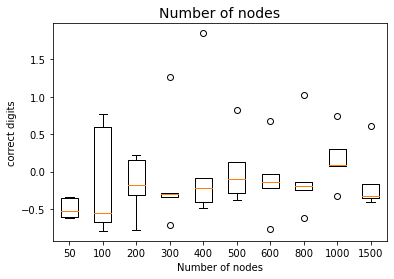

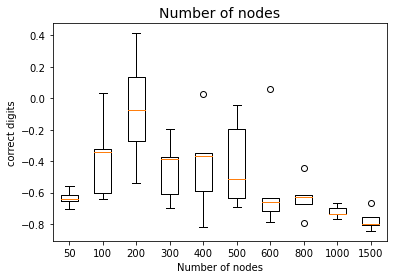

In [469]:
fig, ax = plt.subplots()
ax.boxplot(RL_k.values())
ax.set_xticklabels(RL_k.keys())
plt.title("Number of nodes", fontsize=14)
plt.xlabel('Number of nodes')
plt.ylabel('correct digits')
plt.show()

fig, ax = plt.subplots()
ax.boxplot(SL_k.values())
ax.set_xticklabels(SL_k.keys())
plt.title("Number of nodes", fontsize=14)
plt.xlabel('Number of nodes')
plt.ylabel('correct digits')
plt.show()

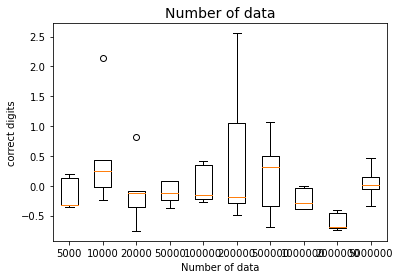

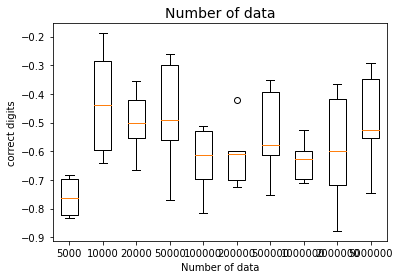

In [477]:
fig, ax = plt.subplots()
ax.boxplot(RL_n.values())
ax.set_xticklabels(RL_n.keys())
plt.title("Number of data", fontsize=14)
plt.xlabel('Number of data')
plt.ylabel('correct digits')
plt.show()

fig, ax = plt.subplots()
ax.boxplot(SL_n.values())
ax.set_xticklabels(SL_n.keys())
plt.title("Number of data", fontsize=14)
plt.xlabel('Number of data')
plt.ylabel('correct digits')
plt.show()